# REVENUE FORECAST

In [54]:
# Import Libraries
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
from numpy import fft
from sklearn.metrics import mean_squared_error
import math
from scipy import stats
import matplotlib.gridspec as gridspec
from datetime import datetime
from calendar import monthrange

In [2]:
# Params
pd.set_option('display.max_rows', 20)
Analysis = False
Plot = True
Local = False
Manual = True

In [57]:
revenue_train = pd.read_csv('C://Users/niccolo/Desktop/Revenue_Forecast/Data/Sample/Revenue_train.csv')
regressor_train = pd.read_csv('C://Users/niccolo/Desktop/Revenue_Forecast/Data/Sample/Regressor_train.csv')
regressor_test = pd.read_csv('C://Users/niccolo/Desktop/Revenue_Forecast/Data/Sample/Regressor_test.csv')

#### Revenue Dataset

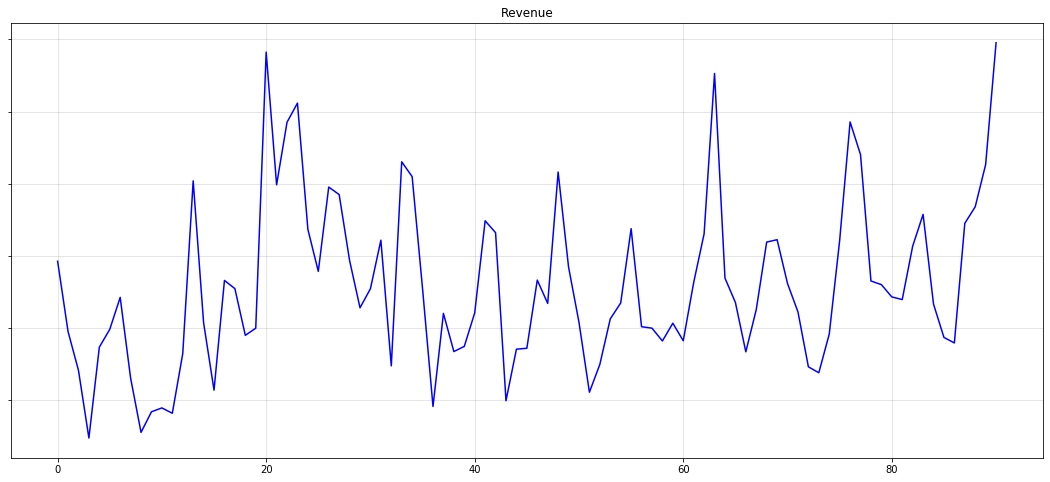

In [107]:
fig = plt.figure(figsize=(18.5,8))
ax = fig.add_subplot(111)
ax.plot(revenue_train.REVENUE, 'blue')
ax.set_yticklabels([])
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_title('Revenue')
plt.show()

#### Train Regressors

In [59]:
pd.DataFrame(regressor_train.values)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1/12/2019,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,1,1,0,0
1,2/12/2019,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0
2,3/12/2019,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0
3,4/12/2019,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5/12/2019,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,25/2/2020,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0
87,26/2/2020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
88,27/2/2020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
89,28/2/2020,1,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,1


#### Test Regressors

In [60]:
pd.DataFrame(regressor_test.values)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1/3/2020,1,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,1
1,2/3/2020,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0
2,3/3/2020,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0
3,4/3/2020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5/3/2020,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,27/3/2020,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0
27,28/3/2020,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0
28,29/3/2020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29,30/3/2020,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0


##### Functions

In [61]:
# Get Confidence Interval
def getCI(x,y,danger):  
    n = len(x)
    sum_errs = np.sum((x - y)**2)
    stdev = np.sqrt(1/(len(x)-2) * sum_errs)
    Conf_Interval = stdev * scipy.stats.t.ppf((1 + danger) / 2, n - 1)
    return Conf_Interval


# Fourier Prediction
def fourierExtrapolation(x, n_predict, harmonics, keep_trend=True):
    n = x.size
    n_harm = harmonics                     
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         
    x_notrend = x - p[0] * t        
    x_freqdom = fft.fft(x_notrend)  
    f = fft.fftfreq(n)              
    indexes = list(range(n))            
    indexes.sort(key=lambda i: np.absolute(x_freqdom[i])) 
    indexes.reverse()    
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n
        phase = np.angle(x_freqdom[i])
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    if keep_trend:
        return restored_sig + p[0] * t
    else:
        return restored_sig

In [62]:
# Train Set
regs_train = regressor_train.iloc[:,1:].values
# Test Set
regs_test = regressor_test.iloc[:,1:].values

#### Fourier Extrapolation: TS Seasonality

In [77]:
# Harmonics Method    
maxdate='2020-03-01'
n_predict = monthrange(datetime.strptime(maxdate, '%Y-%m-%d').year, datetime.strptime(maxdate, '%Y-%m-%d').month)[1]
prediction = fourierExtrapolation(revenue_train.REVENUE, n_predict, 1, True)

#### Choosing Either Prediction with trend or not

In [78]:
# Get Noise
noise = revenue_train.REVENUE - prediction[:-n_predict]

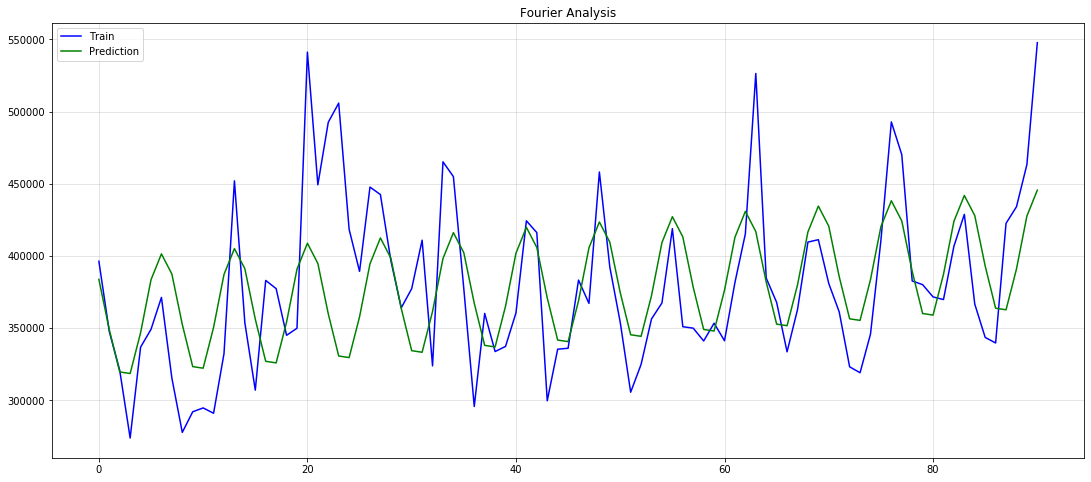

In [79]:
fig = plt.figure(figsize=(18.5,8))
plt.plot(revenue_train.REVENUE, 'blue')
plt.plot(prediction[:-n_predict], 'green')
plt.legend(['Train','Prediction'],fontsize = 'medium')
plt.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
plt.title('Fourier Analysis')
plt.show()

#### Noise Prediction

In [80]:
# Predicts Train and Test
from sklearn.ensemble import RandomForestRegressor
regressor_RF = RandomForestRegressor(n_estimators=300, criterion='mse', random_state = 0)
regressor_RF.fit(regs_train, noise)
predict_RF_train = regressor_RF.predict(regs_train)
predict_RF_test = regressor_RF.predict(regs_test)
forecast = predict_RF_test+prediction[-n_predict:]
forecast_ds = regressor_test.EVTDATEUTC

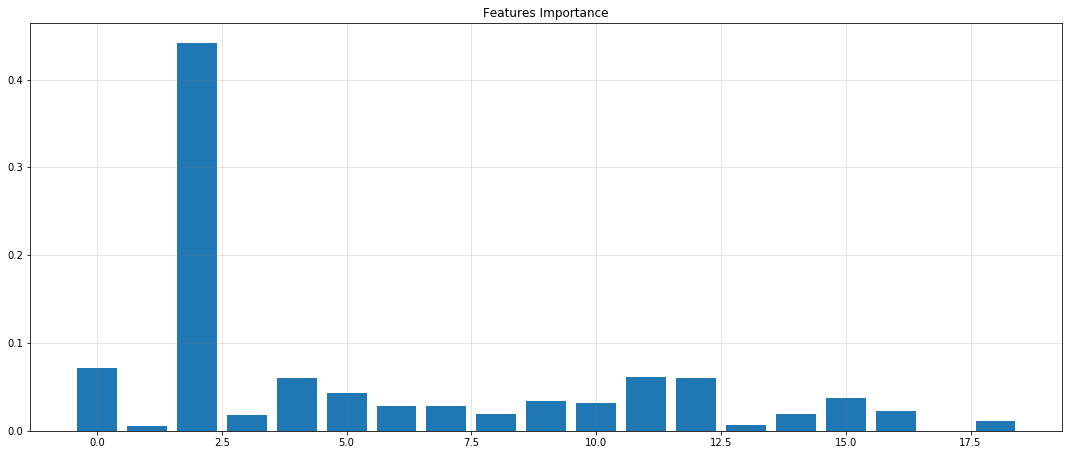

In [81]:
plt.figure(figsize=(18.5,7.5))
plt.bar(np.arange(0,19),regressor_RF.feature_importances_)
plt.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
plt.title('Features Importance')
plt.show()

In [82]:
# Print Root Mean Square Errorand CI  
x = np.array(revenue_train.REVENUE.reset_index(drop=True))
y = np.array(predict_RF_train+prediction[:-n_predict])
rel_rmse = math.sqrt(mean_squared_error(x, y))/(x.mean()**int(x.mean()!=0))
print('rel_rmse: '+str(round(rel_rmse, 6)))
conf_interval = getCI(x, y, 0.85)

rel_rmse: 0.076102


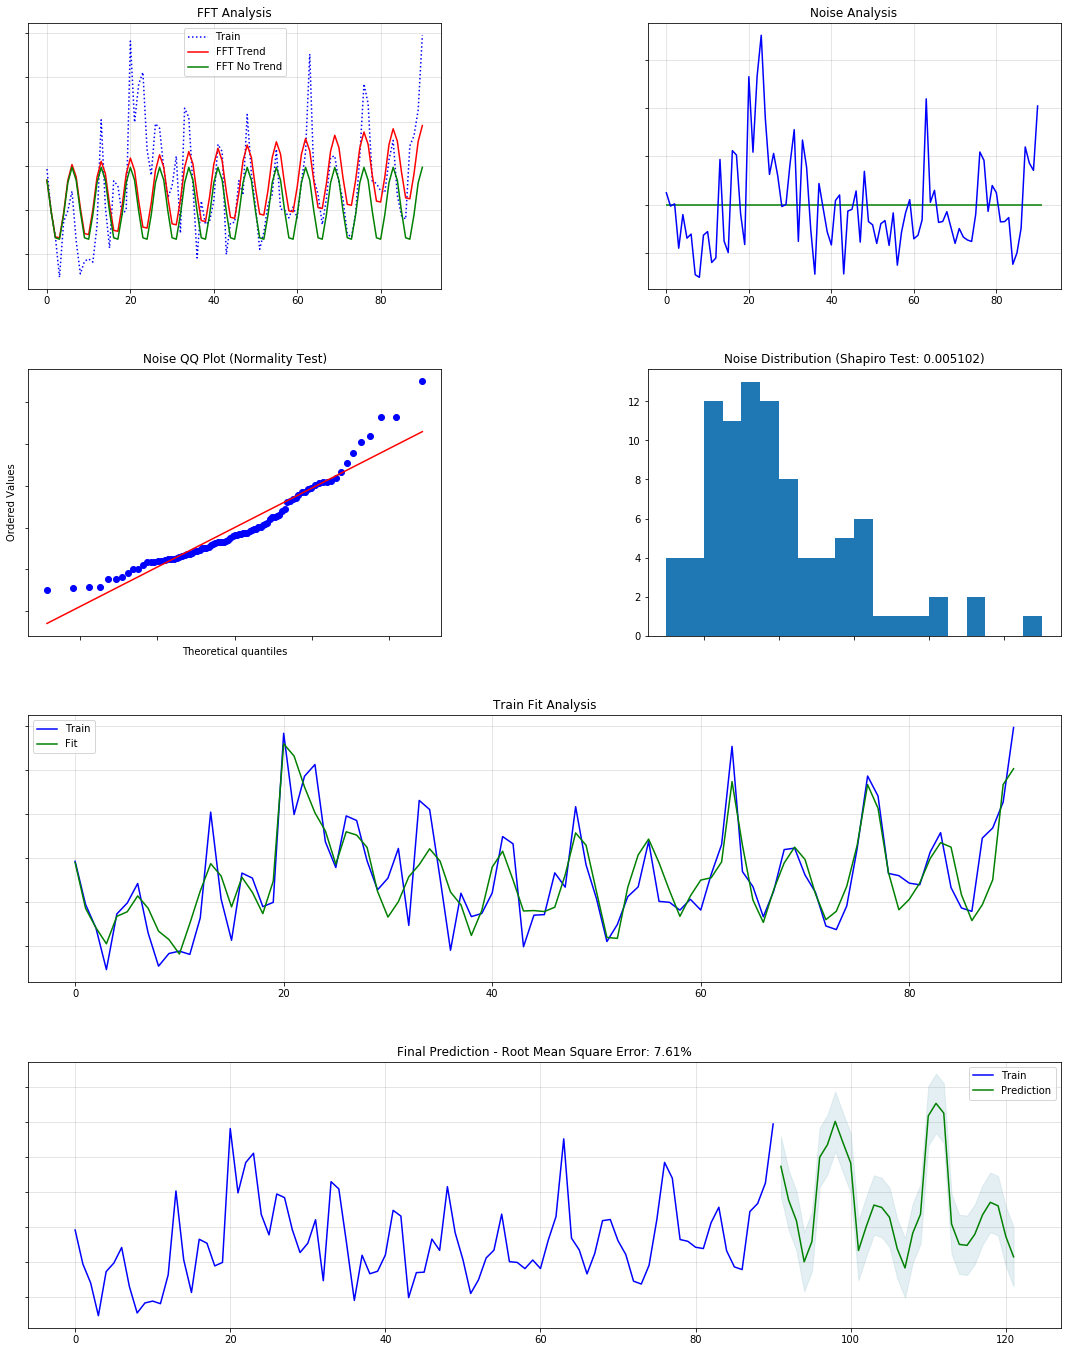

In [114]:
fig = plt.figure(figsize=(18.5,24))
gs = gridspec.GridSpec(nrows=4, 
                       ncols=2, 
                       figure=fig, 
                       width_ratios= [1, 1],
                       height_ratios=[1, 1, 1, 1],
                       wspace=0.5,
                       hspace=0.3)
ax1 = fig.add_subplot(gs[0,0:1])
ax2 = fig.add_subplot(gs[0,1:2])
ax3 = fig.add_subplot(gs[1,0:1])
ax4 = fig.add_subplot(gs[1,1:2]) 
ax5 = fig.add_subplot(gs[2,:])
ax6 = fig.add_subplot(gs[3,:])
ax1.plot(revenue_train.REVENUE, 'blue', linestyle = 'dotted')
ax1.plot(prediction_trend[:-n_predict], 'red')
ax1.plot(prediction_no_trend[:-n_predict], 'green')
ax1.legend(['Train','FFT Trend', 'FFT No Trend'],fontsize = 'medium')
ax1.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax1.set_title('FFT Analysis')
ax1.set_yticklabels([])
ax2.plot(noise, 'blue')
ax2.hlines(0, 0, len(noise), 'green')
ax2.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax2.set_title('Noise Analysis')
ax2.set_yticklabels([])
stats.probplot(noise, dist="norm", plot=ax3)   
ax3.set_title("Noise QQ Plot (Normality Test)")
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax4.hist(noise, bins=20)
ax4.set_title('Noise Distribution (Shapiro Test: '+str(round(stats.shapiro(x)[1],6))+')')
ax4.set_xticklabels([])
ax5.plot(revenue_train.REVENUE, 'blue')
ax5.plot(predict_RF_train+prediction[:-n_predict], 'green')
ax5.legend(['Train','Fit'],fontsize = 'medium')
ax5.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax5.set_title('Train Fit Analysis')
ax5.set_yticklabels([])
ax6.plot(revenue_train.REVENUE, 'blue')
ax6.plot(np.arange(len(revenue_train.REVENUE),len(revenue_train.REVENUE)+n_predict), forecast, 'green')
ax6.set_yticklabels([])
ax6.legend(['Train','Prediction'],fontsize = 'medium')
ax6.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax6.set_title('Final Prediction - Root Mean Square Error: '+str(round(rel_rmse*100,2))+'%')
ax6.fill_between(np.arange(len(revenue_train.REVENUE),len(revenue_train.REVENUE)+n_predict), 
                 np.array(forecast-conf_interval),np.array(forecast+conf_interval),color = '#bad7df', alpha = 0.4)
plt.show()